In [12]:
import tensorflow as tf
import gc
tf.keras.backend.clear_session()
gc.collect()

105

Found 5617 images belonging to 4 classes.
Found 701 images belonging to 4 classes.
Found 705 images belonging to 4 classes.
Epoch 1/50
703/703 [==============================] - 192s 272ms/step - loss: 0.9221 - accuracy: 0.6293 - val_loss: 1.7860 - val_accuracy: 0.5007 - lr: 5.0000e-04
Epoch 2/50
703/703 [==============================] - 190s 271ms/step - loss: 0.7444 - accuracy: 0.7061 - val_loss: 1.4535 - val_accuracy: 0.4864 - lr: 5.0000e-04
Epoch 3/50
703/703 [==============================] - 194s 276ms/step - loss: 0.6086 - accuracy: 0.7711 - val_loss: 3.2891 - val_accuracy: 0.4108 - lr: 5.0000e-04
Epoch 4/50
703/703 [==============================] - 197s 281ms/step - loss: 0.5620 - accuracy: 0.7928 - val_loss: 0.6645 - val_accuracy: 0.7489 - lr: 5.0000e-04
Epoch 5/50
703/703 [==============================] - 204s 290ms/step - loss: 0.5099 - accuracy: 0.8086 - val_loss: 0.8663 - val_accuracy: 0.6676 - lr: 5.0000e-04
Epoch 6/50
703/703 [==============================] - 419s 59

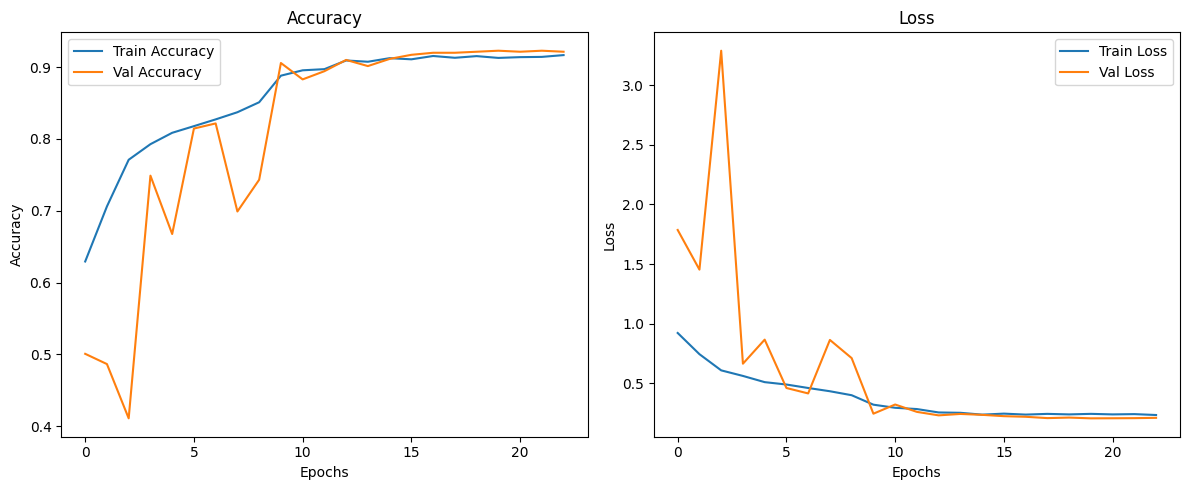

89/89 [==============================] - 6s 64ms/step - loss: 0.2736 - accuracy: 0.9121
✅ Final Test Accuracy: 91.21%
89/89 [==============================] - 6s 63ms/step


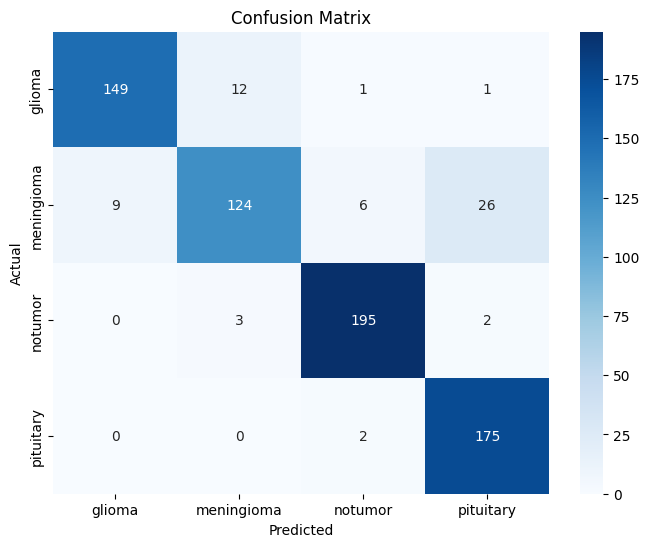

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.91      0.93       163
  meningioma       0.89      0.75      0.82       165
     notumor       0.96      0.97      0.97       200
   pituitary       0.86      0.99      0.92       177

    accuracy                           0.91       705
   macro avg       0.91      0.91      0.91       705
weighted avg       0.91      0.91      0.91       705



In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set paths
base_path = r"C:\Users\rushi\Downloads\Brain Tumor detection"
train_dir = os.path.join(base_path, "training")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "testing")

# Parameters
img_size = 224
batch_size = 8
epochs = 50

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical')

test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=False)

class_names = list(train_gen.class_indices.keys())

# Class Weights
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# ✅ Updated CNN Model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(class_names), activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {test_acc * 100:.2f}%")

# Confusion matrix & Classification report
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [14]:
model.save("brain_tumor_cnn_best_model.h5")


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model
model = load_model("brain_tumor_cnn_best_model.h5")

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [16]:
def predict_image(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    return predicted_class, confidence


1/1 [==============================] - 0s 46ms/step


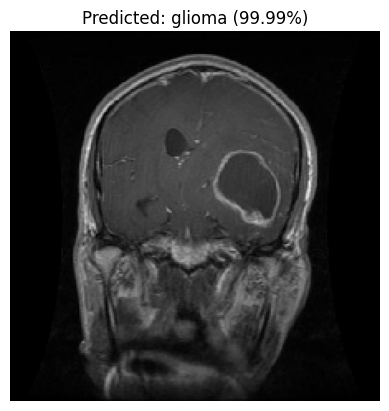

('glioma', 99.99163150787354)

In [18]:
# Example: Test on your own image
img_path = r"C:\Users\rushi\OneDrive\Pictures\Brain Tumor Detection Samples\Tr-gl_0432.jpg"  # Replace with actual path
predict_image(img_path)


1/1 [==============================] - 0s 105ms/step


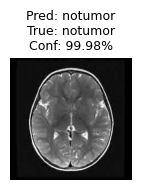

1/1 [==============================] - 0s 20ms/step


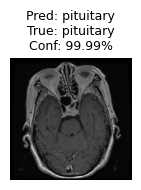

1/1 [==============================] - 0s 24ms/step


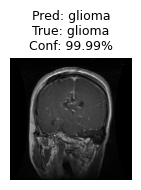

1/1 [==============================] - 0s 23ms/step


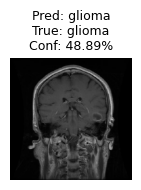

1/1 [==============================] - 0s 21ms/step


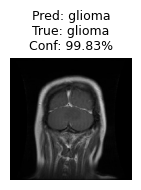

1/1 [==============================] - 0s 19ms/step


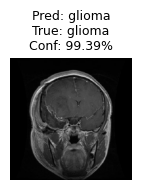

1/1 [==============================] - 0s 21ms/step


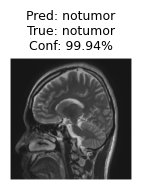

1/1 [==============================] - 0s 21ms/step


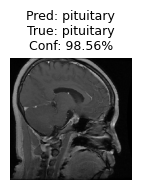

1/1 [==============================] - 0s 20ms/step


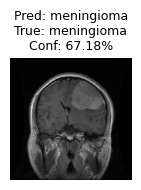

1/1 [==============================] - 0s 20ms/step


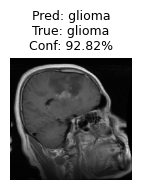

In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the model
model = load_model("brain_tumor_cnn_best_model.h5")

# Define image size and class labels
img_size = 224
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Path to the test directory
test_dir = r"C:\Users\rushi\Downloads\Brain Tumor detection\testing"

# Collect 50 random image paths with their true labels
image_paths = []
true_labels = []

for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    images = os.listdir(class_path)
    selected = random.sample(images, 13 if class_name != 'notumor' else 11)  # total ≈ 50
    for img_name in selected:
        image_paths.append(os.path.join(class_path, img_name))
        true_labels.append(class_name)

# Shuffle together
combined = list(zip(image_paths, true_labels))
random.shuffle(combined)
image_paths[:], true_labels[:] = zip(*combined)

# Predict and show results
correct = 0
for i in range(10):
    img_path = image_paths[i]
    actual_label = true_labels[i]

    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    predicted_index = np.argmax(preds)
    predicted_class = class_names[predicted_index]
    confidence = np.max(preds) * 100

    if predicted_class == actual_label:
        correct += 1

    # Show image with result
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {predicted_class}\nTrue: {actual_label}\nConf: {confidence:.2f}%", fontsize=9)
    plt.tight_layout()
    plt.show()



In [22]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def get_gradcam(model, img_path, class_names, img_size=224, last_conv_layer_name=None):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    # If not specified, find last conv layer
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        pred_index = tf.argmax(predictions[0])
        output = predictions[:, pred_index]

    grads = tape.gradient(output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Multiply gradients with conv outputs
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img_size, img_size))
    heatmap = np.uint8(255 * heatmap)

    # Superimpose
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original = cv2.cvtColor(np.uint8(img_array * 255), cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)

    # Plot result
    pred_class = class_names[pred_index]
    confidence = predictions[0][pred_index].numpy() * 100

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Grad-CAM: {pred_class} ({confidence:.2f}%)")
    plt.tight_layout()
    plt.show()

    return pred_class, confidence


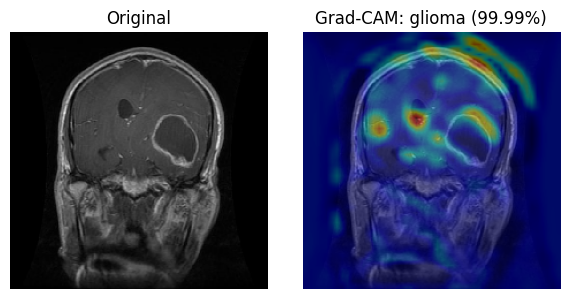

('glioma', 99.99163150787354)

In [23]:
img_path = r"C:\Users\rushi\OneDrive\Pictures\Brain Tumor Detection Samples\Tr-gl_0432.jpg"  # Replace with any test image
get_gradcam(model, img_path, class_names)
